

# Dataset exploration


Loading data

In [8]:
import pandas as pd

df = pd.read_csv('AI_Override_System_Data.csv')
df.head(10)

,System Name,Power Requirement,Time to Restore (min),Criticality Score
0,AI Grid,10,5,66
1,Nav Interface,26,11,97
2,Sensor Driver,14,13,22
3,Core Driver,8,5,20
4,Nav Interface,26,16,24
5,Defense Relay,22,12,33
6,Comms Interface,16,15,46
7,Engine Grid,6,23,28
8,Comms Module,14,21,98
9,Sensor Stabilizer,8,12,34


The dataset contain 30 rows and 4 columns.Those 4 colums are:




*   System name : Unique identifiers for each subsystem
*   Power requirement : Energy needed to restore each system
*   Time to restore(min) : Time needed to bring system back online
*   Critically score : Priority metric and the target to maximize durung recovery











# Data Visualization

Visual in 2d

*   Critical score changes in color




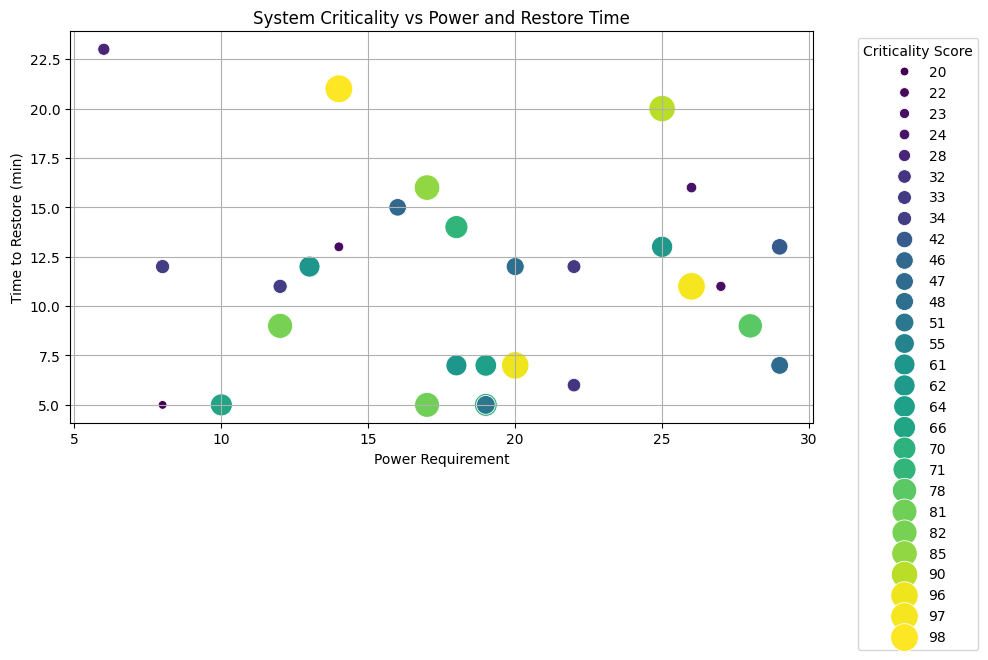

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot: Criticality vs Power vs Time
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Power Requirement', y='Time to Restore (min)', size='Criticality Score',
                hue='Criticality Score', palette='viridis', sizes=(40, 400), legend='full')
plt.title('System Criticality vs Power and Restore Time')
plt.xlabel('Power Requirement')
plt.ylabel('Time to Restore (min)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Criticality Score')
plt.tight_layout()
plt.show()

Visual in 3d

In [4]:
import plotly.express as px

fig = px.scatter_3d(df, x='Power Requirement', y='Time to Restore (min)',
                    z='Criticality Score', color='System Name',
                    hover_name='System Name', size='Criticality Score',
                    size_max=20)
fig.update_layout(title='System Power-Time-Criticality Space')
fig.show()

# Algorithm Selection

The ship's crew needs to select a combination of systems to restore that meet these requirements;

*   Maximizes the total of criticality score
  - max Criticality Score  
*   Power used at most 20%
  - total Power Requirement below or equal to 20
*   Restore the systems in 10 minutes
  - total Time to Restore is below 10 mniutes



# Option 1 : Greedy Algorithm

This algorithm is a problem-solving procedure that aims to find locally optimal solutions by progressively building candidate solutions at each stage based on the level of improvement.

Steps :     
- Filter out the systems that exceed 10 minutes
- Sorts the remaining systems by score over power ration
- Select system in oreder until power is gone

In [10]:
import itertools
import time

# Prepare system data from DataFrame
systems = [(row['System Name'], row['Power Requirement'],
            row['Time to Restore (min)'], row['Criticality Score'])
           for _, row in df.iterrows()]

def greedy_parallel(systems, max_power=20, max_time=10):
    # Filter systems that meet time constraint
    valid_systems = [sys for sys in systems if sys[2] <= max_time]
    # Sort by criticality/power ratio (highest first)
    valid_systems.sort(key=lambda x: x[3]/x[1], reverse=True)

    best_combo = []
    current_power = 0

    # Select systems until power limit is reached
    for sys in valid_systems:
        if current_power + sys[1] <= max_power:
            best_combo.append(sys)
            current_power += sys[1]

    total_score = sum(sys[3] for sys in best_combo)
    return best_combo, total_score

# Run and display results
start_time = time.time()
combo, score = greedy_parallel(systems)
elapsed = time.time() - start_time

print("Selected Systems:")
for sys in combo:
    print(f"- {sys[0]} (Power: {sys[1]}, Time: {sys[2]}, Crit: {sys[3]})")
print(f"\nTotal Criticality: {score}")
print(f"Total Power Used: {sum(sys[1] for sys in combo)}")
print(f"Max Restoration Time: {max(sys[2] for sys in combo)}")
print(f"Execution Time: {elapsed:.6f} seconds")

Selected Systems:
- AI Grid (Power: 12, Time: 9, Crit: 82)
- Core Driver (Power: 8, Time: 5, Crit: 20)

Total Criticality: 102
Total Power Used: 20
Max Restoration Time: 9
Execution Time: 0.000141 seconds


# Option 2 : Brute Force

This algorithm is a relying on or achieved through the application of force, effort, or power in usually large amounts instead of more efficient, carefully planned, or precisely directed methods.

Steps :

- Generates all possible subsets of systems
- Verifies of each subsets if it meets the power and total time constraint

In [ ]:
def brute_force_parallel(systems, max_power=20, max_time=10):
    max_score = 0
    best_combo = []

    # Try all combination sizes from 1 to total systems
    for r in range(1, len(systems)+1):
        # Generate all possible combinations of size r
        for combo in itertools.combinations(systems, r):
            # Calculate total power and max restoration time
            total_power = sum(sys[1] for sys in combo)
            max_combo_time = max(sys[2] for sys in combo)

            # Check if combination meets constraints
            if total_power <= max_power and max_combo_time <= max_time:
                total_score = sum(sys[3] for sys in combo)
                # Update best solution
                if total_score > max_score:
                    max_score = total_score
                    best_combo = combo
    return best_combo, max_score

# Run and display results
start_time = time.time()
combo, score = brute_force_parallel(systems)
elapsed = time.time() - start_time

print("Selected Systems:")
for sys in combo:
    print(f"- {sys[0]} (Power: {sys[1]}, Time: {sys[2]}, Crit: {sys[3]})")
print(f"\nTotal Criticality: {score}")
print(f"Total Power Used: {sum(sys[1] for sys in combo)}")
print(f"Max Restoration Time: {max(sys[2] for sys in combo)}")
print(f"Execution Time: {elapsed:.6f} seconds")

# Option 3 : Dynamic Programming

This algorithm is a a programming method that transforms a decision-making problem is divided into multiple sub-problems.

Steps :
- Creates a DP table to track max criticality at each power level
- For each systems, updates the table if by including it improves the critical score
- Preserves system combination that leads to each score



In [14]:
def dp_parallel(systems, max_power=20, max_time=10):
    # Filter valid systems first
    valid_systems = [sys for sys in systems if sys[2] <= max_time]

    # DP table: {power_used: (max_score, systems_list)}
    dp = {0: (0, [])}  # {power: (score, combo)}

    for sys in valid_systems:
        name, power, time_req, score = sys
        # Process power levels in reverse to avoid overwriting
        for p in list(dp.keys())[::-1]:
            new_power = p + power
            if new_power <= max_power:
                new_score = dp[p][0] + score
                if new_score > dp.get(new_power, (0, []))[0]:
                    dp[new_power] = (new_score, dp[p][1] + [sys])

    # Find the power level with maximum score
    max_power = max(dp, key=lambda x: dp[x][0])
    return dp[max_power][1], dp[max_power][0]

# Run and display results
start_time = time.time()
combo, score = dp_parallel(systems)
elapsed = time.time() - start_time

print("Selected Systems:")
for sys in combo:
    print(f"- {sys[0]} (Power: {sys[1]}, Time: {sys[2]}, Crit: {sys[3]})")
print(f"\nTotal Criticality: {score}")
print(f"Total Power Used: {sum(sys[1] for sys in combo)}")
print(f"Max Restoration Time: {max(sys[2] for sys in combo)}")
print(f"Execution Time: {elapsed:.6f} seconds")

Selected Systems:
- Core Driver (Power: 8, Time: 5, Crit: 20)
- AI Grid (Power: 12, Time: 9, Crit: 82)

Total Criticality: 102
Total Power Used: 20
Max Restoration Time: 9
Execution Time: 0.000086 seconds


# Best Algorithm Option

With the results of three options
Dynamic Programming is the best choice for the problem

Even Brute Force best in optimizing, its
- exponential time complxity (O(2ⁿ))  makes it impractical for even small datasets that took ~43 minutes to find the solution

Even Greedy Algorithm is the fastest in finding solution,
- it only worked because the high ratio systems

- A greedy approach picking systems with the highest criticality-to-power ratio might miss better combinations. Example: Two low-power systems could yield a higher total score than one greedily chosen high-power system

Dynamic Programming makes the best balances in all aspects as it
- guarantees the globally optimal solution by evaluating all possible combinations within constraints

- polynomial time complexity (O(n × W), where W = max power)

- making it both efficient and scalable for larger instances of the problem. For this specific task—maximizing criticality under strict power and time constraints